In [1]:
import numpy as np
import torch
import os
import pandas as pd
import itertools as it
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Models/utils_no_KC.py .
from utils_no_KC import *

# !pip install optuna
# import optuna

In [3]:
!pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, Summer

In [4]:
def read_range(f_path, segment_index, device):
  sub_dif = pd.read_csv(f_path, header=None).iloc[:, segment_index]
  sub_dif = sub_dif.reset_index(inplace=False, drop=True)
  sub_dif = sub_dif.to_numpy().reshape(-1, len(segment_index)*3)
  sub_dif = torch.from_numpy(sub_dif).to(device)
  return sub_dif

def nRMSE_compute():
    tot_loss = torch.sum(torch.sum(((L_tar.to(device) - L_pred.to(device))/my_range)** 2))
    tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
    return tot_loss

def RMSE_compute():
    tot_loss = torch.sum(torch.sum(((L_tar.to(device) - L_pred.to(device)))** 2))
    tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
    return tot_loss


def r2_compute():
    scaler = StandardScaler()
    scaled_y_true = scaler.fit_transform(L_tar.reshape(-1, 1))
    scaled_y_pred = scaler.transform(L_pred.reshape(-1, 1))

    r2 = r2_score(scaled_y_true, scaled_y_pred)
    return r2

In [5]:
input_frames, predicted_frames, my_stride = 25, 1, 1
num_of_sub = 20
val_sub = [2, 8, 9, 14]
test_sub = [13, 15]
segment_inds = [0, 1, 2, 3]
body_segment_name = 'Head'

In [6]:
# path to proceesed folder
proceesed_path = '/content/drive/MyDrive/DATA/Normalized'
val_pathes = []
for i in val_sub:
  val_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

test_pathes = []
for i in test_sub:
  test_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

path_to_subject_mean = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'mean.csv')
path_to_subject_std = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'std.csv')
path_to_subject_range = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'dif.csv')

path_to_folder = '/content/drive/MyDrive/Models/Transformer_Head'

In [7]:
val_pathes, test_pathes

(['/content/drive/MyDrive/DATA/Normalized/s2_fn',
  '/content/drive/MyDrive/DATA/Normalized/s8_fn',
  '/content/drive/MyDrive/DATA/Normalized/s9_fn',
  '/content/drive/MyDrive/DATA/Normalized/s14_fn'],
 ['/content/drive/MyDrive/DATA/Normalized/s13_fn',
  '/content/drive/MyDrive/DATA/Normalized/s15_fn'])

In [8]:
Val_List = []
Test_List = []
my_path_list = []

for val_path in val_pathes:
  test_ls, segment_len, _ = read_test(val_path, body_segment_name)
  Val_List.extend(test_ls)

print(len(test_ls), test_ls[0].shape)

for test_path in test_pathes:
  test_ls, segment_len, my_pth_ls = read_test(test_path, body_segment_name)
  my_path_list.extend(my_pth_ls)
  Test_List.extend(test_ls)

print(len(test_ls), test_ls[0].shape)

196 (101, 19)
201 (101, 19)


In [ ]:
train_data = []
val_data = []
test_data = []

for i in range(1, num_of_sub+1):
  if i in val_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    val_data.extend(dd)
  elif i in test_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    test_data.extend(dd)
  else:
    dd, _ = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    train_data.extend(dd)




In [ ]:
len(train_data), len(val_data), len(test_data)

(199576, 57912, 30780)

## Data Loader

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [10]:
my_mean = pd.read_csv(path_to_subject_mean, header=None).iloc[:, segment_inds]
my_std = pd.read_csv(path_to_subject_std, header=None).iloc[:, segment_inds]
my_range = read_range(path_to_subject_range, segment_inds, device)

denormalize_transform = Denormalizer(my_mean, my_std, predicted_frames, device)
tot_denormalize_transform = Denormalizer(my_mean, my_std, 101, device)

train_ds = MyDataset(train_data)
val_ds = MyDataset(val_data)
test_ds = MyDataset(test_data)

NameError: ignored

In [11]:
batch_size = 512
train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                      shuffle=True)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                      shuffle=True)

NameError: ignored

# Model Implementation

In [12]:
class TransformerBased(nn.Module):
  def __init__(self, in_ftrs, d_model=64, num_head=8, num_feed_forward=2048, drop_trans=0.2, enc_num_layers=1, dec_num_layers=1, drop_fc=0.01, out_neurons=100):
    super(TransformerBased, self).__init__()
    self.in_ftrs = in_ftrs
    self.d_model = d_model
    self.out_neurons = out_neurons

    self.dim_expander = nn.Linear(self.in_ftrs, self.d_model)

    self.p_enc = Summer(PositionalEncoding1D(self.d_model))

    self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=num_head,
                                                    dim_feedforward=num_feed_forward,
                                                    dropout=drop_trans, batch_first=True),
                                          num_layers=enc_num_layers)


    self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=num_head,
                                                     dim_feedforward=num_feed_forward,
                                                     dropout=drop_trans, batch_first=True),
                          num_layers=dec_num_layers)

    self.fc = nn.Sequential(nn.Linear(self.d_model, self.out_neurons),
                            nn.ReLU(),
                            nn.Dropout(drop_fc),
                            nn.Linear(self.out_neurons, self.in_ftrs-7))

  def forward(self, src):
    tgt = src[:, -1, :].unsqueeze(1)
    src = self.dim_expander(src)
    tgt = self.dim_expander(tgt)
    src = self.p_enc(src)
    tgt = self.p_enc(tgt)
    encoded = self.encoder(src)
    out = self.decoder(tgt, encoded)
    out = self.fc(out)
    return out


In [ ]:
model = TransformerBased(19, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)

TransformerBased(
  (dim_expander): Linear(in_features=19, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [ ]:
count_parameters(model)

667404

# HyperParameter Tuning

In [ ]:
def objective(trial):
    epochs = 15

    # Define hyperparameters
    d_model = trial.suggest_categorical("d_model", [64, 96, 128])
    num_head = trial.suggest_categorical("num_head", [8, 16, 32])
    num_feed_forward = trial.suggest_categorical("num_feed_forward", [256, 512, 1024, 2048])
    drop_trans = trial.suggest_categorical("drop_trans", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    enc_num_layers = trial.suggest_categorical("enc_num_layers", [1, 2, 3, 4])
    dec_num_layers = trial.suggest_categorical("dec_num_layers", [1, 2, 3, 4])
    out_neurons = trial.suggest_categorical("out_neurons", [64, 128, 256])
    drop_fc = trial.suggest_categorical("drop_fc", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    # l_r = trial.suggest_categorical("l_r", [0.05, 0.01, 0.001])


    # Create and train the model
    model = TransformerBased(2*7*3+7, d_model, num_head, num_feed_forward, drop_trans, enc_num_layers, dec_num_layers, drop_fc=drop_fc, out_neurons=out_neurons).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-09)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)

    for step in range(epochs):
        train_loss = train_loop(model,
                        criterion,
                        optimizer,
                        train_dl,
                        test_dl,
                        epochs,
                        scheduler,
                        denormalize_transform,
                        device)

        val_loss = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)

        scheduler.step(val_loss)
        trial.report(val_loss, step)

        if trial.should_prune():
            raise optuna.TrialPruned()


    return val_loss

study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5, n_warmup_steps= 10, interval_steps=1
    ))
study.optimize(objective, n_trials=150)

[I 2023-08-04 08:43:25,804] A new study created in memory with name: no-name-483639b5-e09b-4842-8a3b-370fd8738f29
[I 2023-08-04 08:49:29,543] Trial 0 finished with value: 764.1268998762217 and parameters: {'d_model': 96, 'num_head': 16, 'num_feed_forward': 256, 'drop_trans': 0.4, 'enc_num_layers': 2, 'dec_num_layers': 4, 'out_neurons': 128, 'drop_fc': 0.45}. Best is trial 0 with value: 764.1268998762217.
[I 2023-08-04 08:56:49,912] Trial 1 finished with value: 698.0617828997074 and parameters: {'d_model': 128, 'num_head': 32, 'num_feed_forward': 1024, 'drop_trans': 0.35, 'enc_num_layers': 2, 'dec_num_layers': 3, 'out_neurons': 64, 'drop_fc': 0.3}. Best is trial 1 with value: 698.0617828997074.


Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


[I 2023-08-04 09:00:08,670] Trial 2 finished with value: 1686.4997312443736 and parameters: {'d_model': 128, 'num_head': 32, 'num_feed_forward': 256, 'drop_trans': 0.2, 'enc_num_layers': 1, 'dec_num_layers': 1, 'out_neurons': 64, 'drop_fc': 0.5}. Best is trial 1 with value: 698.0617828997074.
[I 2023-08-04 09:08:03,345] Trial 3 finished with value: 288.1352475013262 and parameters: {'d_model': 96, 'num_head': 32, 'num_feed_forward': 512, 'drop_trans': 0.25, 'enc_num_layers': 3, 'dec_num_layers': 3, 'out_neurons': 256, 'drop_fc': 0.25}. Best is trial 3 with value: 288.1352475013262.
[I 2023-08-04 09:13:13,333] Trial 4 finished with value: 1570.0141104239005 and parameters: {'d_model': 128, 'num_head': 8, 'num_feed_forward': 256, 'drop_trans': 0.3, 'enc_num_layers': 2, 'dec_num_layers': 3, 'out_neurons': 64, 'drop_fc': 0.45}. Best is trial 3 with value: 288.1352475013262.


Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.


[I 2023-08-04 09:18:30,123] Trial 5 finished with value: 188.8275732346523 and parameters: {'d_model': 64, 'num_head': 16, 'num_feed_forward': 1024, 'drop_trans': 0.3, 'enc_num_layers': 1, 'dec_num_layers': 4, 'out_neurons': 256, 'drop_fc': 0.35}. Best is trial 5 with value: 188.8275732346523.
[I 2023-08-04 09:27:50,676] Trial 6 finished with value: 652.3240399144804 and parameters: {'d_model': 128, 'num_head': 32, 'num_feed_forward': 2048, 'drop_trans': 0.5, 'enc_num_layers': 2, 'dec_num_layers': 4, 'out_neurons': 128, 'drop_fc': 0.35}. Best is trial 5 with value: 188.8275732346523.
[I 2023-08-04 09:34:06,813] Trial 7 finished with value: 420.33014305334524 and parameters: {'d_model': 128, 'num_head': 8, 'num_feed_forward': 512, 'drop_trans': 0.35, 'enc_num_layers': 4, 'dec_num_layers': 1, 'out_neurons': 256, 'drop_fc': 0.45}. Best is trial 5 with value: 188.8275732346523.


Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.


[I 2023-08-04 09:40:22,838] Trial 8 finished with value: 358.55417837135093 and parameters: {'d_model': 96, 'num_head': 16, 'num_feed_forward': 256, 'drop_trans': 0.25, 'enc_num_layers': 3, 'dec_num_layers': 3, 'out_neurons': 256, 'drop_fc': 0.5}. Best is trial 5 with value: 188.8275732346523.
[I 2023-08-04 09:43:51,133] Trial 9 finished with value: 348.3151500058272 and parameters: {'d_model': 96, 'num_head': 8, 'num_feed_forward': 256, 'drop_trans': 0.2, 'enc_num_layers': 2, 'dec_num_layers': 1, 'out_neurons': 128, 'drop_fc': 0.3}. Best is trial 5 with value: 188.8275732346523.
[I 2023-08-04 09:47:33,527] Trial 10 finished with value: 242.98936336815603 and parameters: {'d_model': 64, 'num_head': 16, 'num_feed_forward': 1024, 'drop_trans': 0.3, 'enc_num_layers': 1, 'dec_num_layers': 2, 'out_neurons': 256, 'drop_fc': 0.35}. Best is trial 5 with value: 188.8275732346523.
[I 2023-08-04 09:51:14,351] Trial 11 finished with value: 261.35558466656215 and parameters: {'d_model': 64, 'num_he

Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


[I 2023-08-04 10:22:00,009] Trial 16 finished with value: 113.49726233462738 and parameters: {'d_model': 64, 'num_head': 16, 'num_feed_forward': 2048, 'drop_trans': 0.45, 'enc_num_layers': 4, 'dec_num_layers': 2, 'out_neurons': 256, 'drop_fc': 0.2}. Best is trial 16 with value: 113.49726233462738.


Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


[I 2023-08-04 10:31:10,196] Trial 17 finished with value: 121.90929532149201 and parameters: {'d_model': 64, 'num_head': 16, 'num_feed_forward': 2048, 'drop_trans': 0.45, 'enc_num_layers': 4, 'dec_num_layers': 2, 'out_neurons': 256, 'drop_fc': 0.2}. Best is trial 16 with value: 113.49726233462738.
[I 2023-08-04 10:40:24,314] Trial 18 finished with value: 274.6616775449902 and parameters: {'d_model': 64, 'num_head': 16, 'num_feed_forward': 2048, 'drop_trans': 0.45, 'enc_num_layers': 4, 'dec_num_layers': 2, 'out_neurons': 128, 'drop_fc': 0.2}. Best is trial 16 with value: 113.49726233462738.
[I 2023-08-04 10:46:25,878] Trial 19 pruned. 


Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.


[I 2023-08-04 10:55:41,273] Trial 20 finished with value: 142.70451549639918 and parameters: {'d_model': 64, 'num_head': 16, 'num_feed_forward': 2048, 'drop_trans': 0.5, 'enc_num_layers': 4, 'dec_num_layers': 2, 'out_neurons': 256, 'drop_fc': 0.25}. Best is trial 16 with value: 113.49726233462738.
[I 2023-08-04 11:04:59,477] Trial 21 finished with value: 303.9279953442483 and parameters: {'d_model': 64, 'num_head': 16, 'num_feed_forward': 2048, 'drop_trans': 0.5, 'enc_num_layers': 4, 'dec_num_layers': 2, 'out_neurons': 256, 'drop_fc': 0.4}. Best is trial 16 with value: 113.49726233462738.
[I 2023-08-04 11:14:14,512] Trial 22 finished with value: 184.13333117324137 and parameters: {'d_model': 64, 'num_head': 16, 'num_feed_forward': 2048, 'drop_trans': 0.5, 'enc_num_layers': 4, 'dec_num_layers': 2, 'out_neurons': 256, 'drop_fc': 0.25}. Best is trial 16 with value: 113.49726233462738.
[I 2023-08-04 11:23:32,081] Trial 23 finished with value: 185.7117774241255 and parameters: {'d_model': 6

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
# Get parameters sorted by the importance values
importances = optuna.importance.get_param_importances(study)
params_sorted = list(importances.keys())

# Plot
fig = optuna.visualization.plot_rank(study, params=params_sorted[:4])
fig.show()

<ipython-input-27-835c4a61bc8d>:6: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [ ]:
optuna.visualization.plot_intermediate_values(study)


In [ ]:
optuna.visualization.plot_param_importances(study)


In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [ ]:
import joblib
joblib.dump(study, "study.pkl")

NameError: ignored

In [ ]:
# Load the study from the file
my_study = joblib.load("study.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in my_study.best_trial.params.items():
    print(f"    {key}: {value}")


FileNotFoundError: ignored

# Training Model

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001, betas=(0.9, 0.98), eps=1e-09)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)


In [ ]:
epochs = 200
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
best_test_loss = float('inf')

for it in range(epochs):
  train_losses[it] = train_loop(model,
                                criterion,
                                optimizer,
                                train_dl,
                                val_dl,
                                epochs,
                                scheduler,
                                denormalize_transform,
                                device)

  val_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)
  test_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              test_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)



  if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]:.5f}, Validation Loss: {val_losses[it]:.5f}, Test Loss: {test_losses[it]:.5f}')
  if scheduler is not None:
    scheduler.step(val_losses[it])

  if test_losses[it] < best_test_loss:
    best_test_loss = test_losses[it]
    torch.save(model.state_dict(), "best_test_model_params.pt")
    torch.save(model.state_dict(), os.path.join(path_to_folder, "best_test_model_params.pt"))


Epoch 5/200, Train Loss: 25.69774, Validation Loss: 24.44861, Test Loss: 46.43661
Epoch 10/200, Train Loss: 10.21459, Validation Loss: 14.09843, Test Loss: 23.44333
Epoch 15/200, Train Loss: 6.31495, Validation Loss: 8.66308, Test Loss: 17.66876
Epoch 20/200, Train Loss: 4.67921, Validation Loss: 8.35777, Test Loss: 16.43758
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
Epoch 25/200, Train Loss: 1.11163, Validation Loss: 2.86908, Test Loss: 4.29526
Epoch 30/200, Train Loss: 0.87283, Validation Loss: 2.17428, Test Loss: 3.21140
Epoch 35/200, Train Loss: 0.76890, Validation Loss: 1.95742, Test Loss: 2.49329
Epoch 40/200, Train Loss: 0.66495, Validation Loss: 1.79443, Test Loss: 2.41036
Epoch 45/200, Train Loss: 0.60843, Validation Loss: 1.51805, Test Loss: 2.08965
Epoch 50/200, Train Loss: 0.55510, Validation Loss: 1.41350, Test Loss: 1.92303
Epoch 55/200, Train Loss: 0.50825, Validation Loss: 1.34240, Test Loss: 1.65883
Epoch 60/200, Train Loss: 0.47157, Validation Loss:

In [ ]:
# Save last weights
torch.save(model.state_dict(), os.path.join(path_to_folder, "last_model_params.pt"))

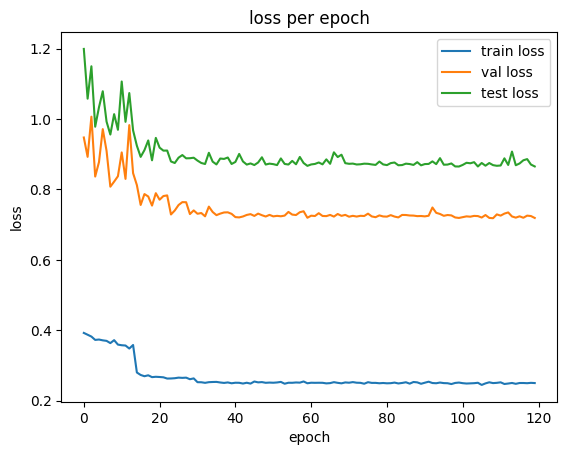

In [ ]:
plt.plot(train_losses[80: ], label='train loss')
plt.plot(val_losses[80:], label='val loss')
plt.plot(test_losses[80:], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
best_test_loss

0.8652407126348527

In [ ]:
i = 0
L_tar = torch.zeros(101*len(Test_List), segment_len)
L_pred = torch.zeros(101*len(Test_List), segment_len)
for j in range(len(Test_List)):
    L_v_tar, L_v_pred = L_Pred(Test_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar[0+i:101+i, :] = L_v_tar
    L_pred[0+i:101+i, :] = L_v_pred
    i = i + 101

In [ ]:
RMSE_loss = RMSE_compute()
nRMSE_loss = nRMSE_compute()
r2_m = r2_compute()
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 53.54658508300781, nRMSE: 0.0488660272518641, r2: 0.9954048254053862


In [ ]:
L_v_tar, L_v_pred = L_Pred(Test_List, 6, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

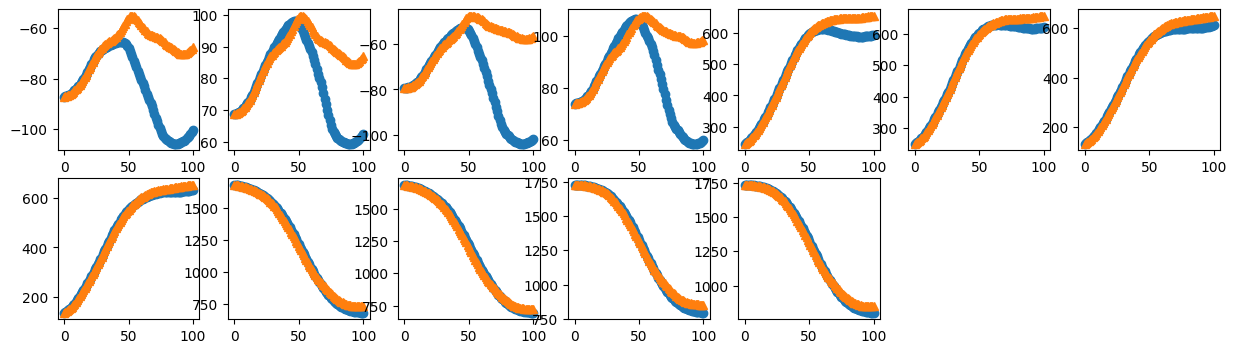

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

In [ ]:
np.where(test_losses == best_test_loss)

(array([179]),)

# Best MSE


In [13]:
# Load best val model
model = TransformerBased(19, d_model=96, num_head=16, num_feed_forward=512, drop_trans=0.25, enc_num_layers=1, dec_num_layers=3, drop_fc=0, out_neurons=64)


model.to(device)
model.load_state_dict(torch.load(os.path.join(path_to_folder, "last_model_params.pt")))
model.eval()

TransformerBased(
  (dim_expander): Linear(in_features=19, out_features=96, bias=True)
  (p_enc): Summer(
    (penc): PositionalEncoding1D()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_pr

In [ ]:
i = 0
L_tar = torch.zeros(101*len(Test_List), segment_len)
L_pred = torch.zeros(101*len(Test_List), segment_len)
for j in range(len(Test_List)):
    L_v_tar, L_v_pred = L_Pred(Test_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar[0+i:101+i, :] = L_v_tar
    L_pred[0+i:101+i, :] = L_v_pred
    i = i + 101

In [ ]:
RMSE_loss = RMSE_compute()
nRMSE_loss = nRMSE_compute()
r2_m = r2_compute()
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 53.546630859375, nRMSE: 0.048866057877823596, r2: 0.99540481745757


In [14]:
L_v_tar, L_v_pred = L_Pred(Test_List, 200, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

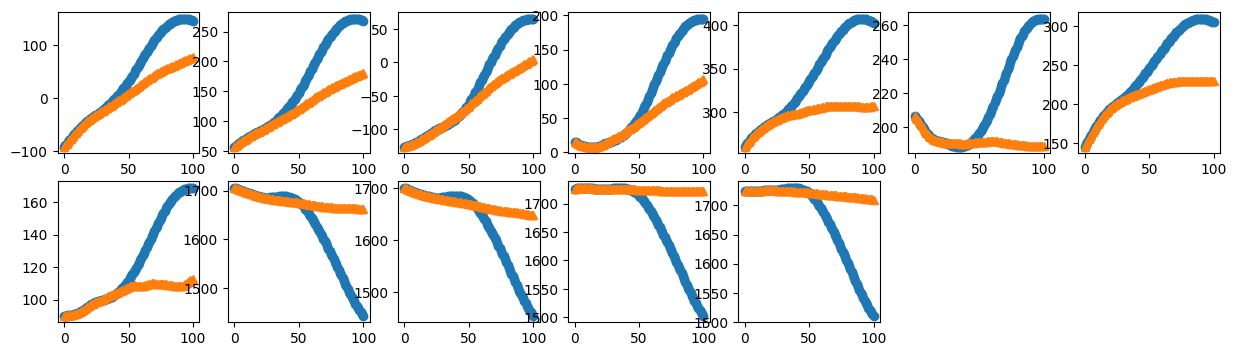

In [15]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

In [16]:
my_path_list[200]

'/content/drive/MyDrive/DATA/Normalized/s13_fn/s13_82_fn.csv'

In [17]:
tartar = pd.DataFrame(L_v_tar.cpu().squeeze())

In [18]:
tartar.to_csv('tar_Head.csv')

In [19]:
per = pd.DataFrame(L_v_pred.cpu().squeeze())

In [20]:
per.to_csv('per.Head.csv')